In [5]:
# === IMPORTS ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# === LOAD DATA ===
df = pd.read_csv("../Motor_vehicle_insurance_data.csv", delimiter=';')

# === CONVERT DATE COLUMNS ===
date_cols = ['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 
             'Date_birth', 'Date_driving_licence', 'Date_lapse']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# === CREATE Renewed TARGET VARIABLE ===
df['Renewed'] = df['Lapse'].apply(lambda x: 1 if x == 0 else 0)

# === FEATURE ENGINEERING WITH FIXED DATE ===
reference_date = pd.to_datetime("2018-12-31")
df['Customer_age'] = (reference_date - df['Date_birth']).dt.days // 365
df['Driving_experience'] = (reference_date - df['Date_driving_licence']).dt.days // 365
df['Contract_duration'] = (df['Date_next_renewal'] - df['Date_start_contract']).dt.days

# === REMOVE DATE-BASED OUTLIERS ===
df = df[(df['Customer_age'] >= 18) & (df['Customer_age'] <= 100)]
df = df[(df['Driving_experience'] >= 0) & (df['Driving_experience'] <= 80)]

# === DROP UNUSED COLUMNS ===
df = df.drop(columns=['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 
                      'Date_birth', 'Date_driving_licence', 'Date_lapse', 'Lapse'])

# === DEFINE FEATURES & TARGET ===
X = df.drop(columns=['Renewed'])
y = df['Renewed']

# === IDENTIFY COLUMN TYPES ===
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)

# === PREPROCESSING PIPELINES ===
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# === MODEL PIPELINE WITH LINEAR REGRESSION ===
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# === TRAIN-TEST SPLIT & MODEL TRAINING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# === PREDICT AND CONVERT TO CLASSES ===
y_pred_continuous = model.predict(X_test)
y_pred_binary = (y_pred_continuous >= 0.5).astype(int)

# === EXPORT MODEL TO MODELS FOLDER ===
joblib.dump(model, "../models/linear_regression_model.pkl")
print("✅ Linear Regression model saved as '../models/linear_regression_model.pkl'")

/var/folders/0x/y70f9b115h59p57bg5dtc2500000gn/T/ipykernel_57432/2299856083.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Motor_vehicle_insurance_data.csv", delimiter=';')


✅ Linear Regression model saved as '../models/linear_regression_model.pkl'


✅ Linear Regression Model Evaluation
------------------------------
Accuracy: 0.7951305006868458
ROC AUC Score: 0.7074570737233348

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.05      0.09      4361
           1       0.80      0.99      0.88     16750

    accuracy                           0.80     21111
   macro avg       0.67      0.52      0.49     21111
weighted avg       0.75      0.80      0.72     21111



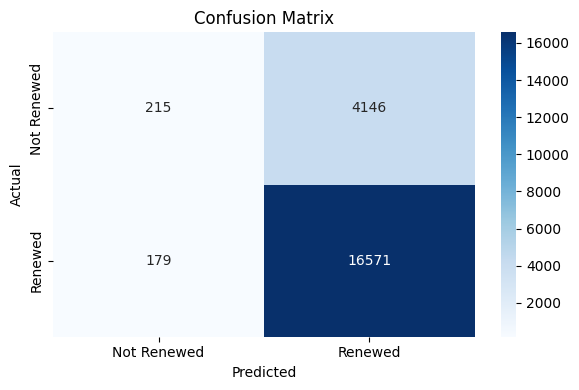

In [6]:
# === IMPORTS ===
import joblib
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === LOAD SAVED LINEAR REGRESSION MODEL ===
model = joblib.load("../models/linear_regression_model.pkl")

# === PREDICT ON TEST SET ===
y_pred_scores = model.predict(X_test)                   # Continuous scores
y_pred = (y_pred_scores >= 0.5).astype(int)             # Convert to 0 or 1
y_prob = y_pred_scores                                  # Use scores for ROC AUC

# === EVALUATE MODEL PERFORMANCE ===
print("✅ Linear Regression Model Evaluation")
print("-" * 30)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === DISPLAY CONFUSION MATRIX ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Renewed', 'Renewed'],
            yticklabels=['Not Renewed', 'Renewed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()